# Exercise 3: Derivatives in Fourier domain

$\textbf{Compute derivatives in the Fourier Domain.}$ <br> 
Computing derivatives in the frequency domain is equivalent to performing multiplications. This is the essence of spectral and pseudospectral methods in CFD. Show it using the DFT definition and then using Python. Is this true everywhere? <br>
Compute velocity and acceleration using spectral differentiation + filtering.

In [1]:
import numpy as np
from scipy import signal
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, get_window, firwin
from scipy.signal.windows import general_hamming
%matplotlib inline

In [2]:
def Diff_1st_order(x,y):
    """ 
    Compute derivatives with first order backward difference approximation:
    y'(xi) = (y(xi)−y(xi−1)) / Δx 
    y''(xi) = (y(xi)−2y(xi−1)+y(xi-2) / Δx^2 
    For the first point (firsts 2 for the 2nd order derivative), 
    The forward difference approximation, that mirrors the expression above, 
    is considered 
    """
    
    N = x.shape[0]
    
    delta_x = np.empty(N)
    y_prime = np.empty(N) # 1st order derivative
    y_prime2 = np.empty(N) # 2nd order derivative
    # Forward first order differencing approx 
    delta_x[0] = x[1] - x[0]
    y_prime[0] = (y[1] - y[0]) / delta_x[0]
    y_prime2[0] = (y[2] - 2*y[1] + y[0]) / delta_x[0]**2
    # Backward first order differencing approx 
    for i in range(1, N):
        delta_x[i] = x[i] - x[i-1]
        y_prime[i] = (y[i] - y[i-1]) / delta_x[i]
        if i == 1:
            y_prime2[i] = (y[i+2] - 2*y[i+1] + y[i]) / delta_x[i]**2
        else:
            y_prime2[i] = (y[i] - 2*y[i-1] + y[i-2]) / delta_x[i]**2
            
    return y_prime, y_prime2

def Diff_2nd_order(x,y):
    """ 
    Compute derivatives with second order central difference approximation:
    y'(xi) = (y(xi+1)−y(xi−1)) / 2Δx 
    y''(xi) = (y(xi+1)−2y(xi)+y(xi-1) / Δx^2 
    The derivatives for the 2 points at the edge, is computed with the forward
    differencing at the left and the backwards one on the right.
    Forward:
    y'(xi) = (-y(xi+2)+4y(xi+1)-3y(xi)) / 2Δx 
    y''(xi) = (-y(xi+3)+4y(xi+2)-5y(xi+1)+2y(xi)) / Δx^2
    Backward:
    y'(xi) = (y(xi-2)-4y(xi-1)+3y(xi)) / 2Δx 
    y''(xi) = (-y(xi-3)+4y(xi-2)-5y(xi-1)+2y(xi)) / Δx^2
    """
    
    N = x.shape[0]
    
    delta_x = np.empty(N)
    # y_prime = np.gradient(y, x, edge_order=2) # 1st order derivative
    y_prime = np.empty(N) # 1st order derivative
    y_prime2 = np.empty(N) # 2nd order derivative
    
    # Forward first order differencing approx 
    delta_x[0] = x[1] - x[0]
    y_prime[0] = (-y[2] + 4*y[1] - 3*y[0]) / (2*delta_x[0])
    y_prime2[0] = (-y[3] + 4*y[2] - 5*y[1] + 2*y[0]) / delta_x[0]**2
    # Central second order differencing approx 
    for i in range(1, N):
        delta_x[i] = x[i] - x[i-1]
        if i == N-1:
            y_prime[i] = (3*y[i] - 4*y[i-1] + y[i-2]) / (2*delta_x[i])
            y_prime2[i] = (-y[i-3] + 4*y[i-2] - 5*y[i-1] + 2*y[i]) / delta_x[i]**2
        else:
            y_prime[i] = (y[i+1] - y[i-1]) / (2*delta_x[i])
            y_prime2[i] = (y[i+1] - 2*y[i] + y[i-1]) / delta_x[i]**2
    
    return y_prime, y_prime2

In [3]:
columns = ['Time','ODS_raw']
n = 500
data_raw = pd.read_excel('Signal_raw092.xlsx', 
                         header=None, skiprows=n+1, names=columns)
x, y = np.array(data_raw.Time), np.array(data_raw['ODS_raw'])
y_prime_1st, y_prime2_1st = Diff_1st_order(x,y) # 1st order schemes
y_prime_2nd, y_prime2_2nd = Diff_2nd_order(x,y) # 2nd order schemes

dt = 0.01 #s
fs = 1/dt # Hz
f_c = 2 #Hz Cut-off frequency
Nt = x.shape[0]


N_O=200 # this is the order of the filter
h_impulse_200 = firwin(N_O, f_c/fs*2, window='hamming') 
y_filt_filt_200=signal.filtfilt(h_impulse_200,1,y)

In [4]:
y_filt_fft=(np.fft.fft(y_filt_filt_200)) 
freqs_fft=freq = np.fft.fftfreq(Nt, d=dt)

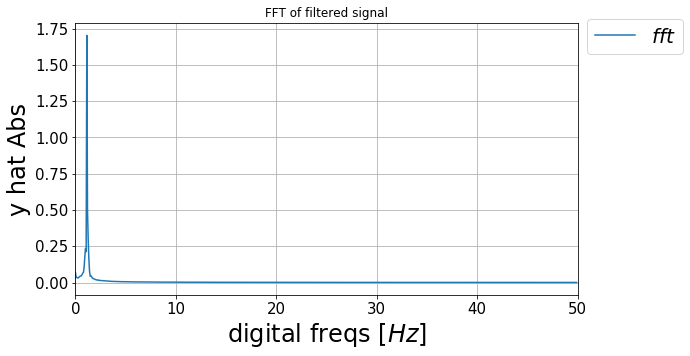

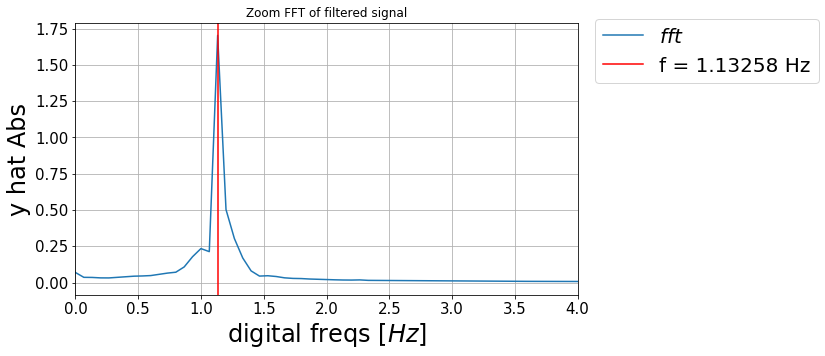

In [5]:
fig, ax = plt.subplots(figsize=(9,5))
plt.plot(freqs_fft[:len(freqs_fft)//2],np.abs(y_filt_fft[:len(y_filt_fft)//2])/Nt,label='$fft$')
plt.legend(fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xlabel('digital freqs $[Hz]$',fontsize=24)
plt.ylabel('y hat Abs',fontsize=24)
plt.xlim([0, 50])
plt.grid()
plt.title('FFT of filtered signal')
plt.legend(bbox_to_anchor=(1.23, 1.05), fontsize=20)
plt.show()

fig, ax = plt.subplots(figsize=(9,5))
plt.plot(freqs_fft[:len(freqs_fft)//2],np.abs(y_filt_fft[:len(y_filt_fft)//2])/Nt,label='$fft$')
plt.axvline(x=1.13258, color='red', label='f = 1.13258 Hz')
plt.legend(fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xlabel('digital freqs $[Hz]$',fontsize=24)
plt.ylabel('y hat Abs',fontsize=24)
plt.xlim([0, 4])
plt.grid()
plt.title('Zoom FFT of filtered signal')
plt.legend(bbox_to_anchor=(1.5, 1.05), fontsize=20)  
plt.show()

## Demonstration derivatives in Fourier domain

From the definition of $\textbf{inverse Fourier transform}$, we have: <br>
$ y(t) = \frac{1}{T} \sum_{k=0}^{N-1} Y_k e^{i \frac{2 \pi}{T} k t}$ <br>
Where $Y_k$ is the Fourier transform of the signal. <br>
Taking time differentiation on both sides, we get: <br>
$ \frac{d}{dt} y(t) = \frac{d}{dt} \left[ \frac{1}{T} \sum_{k=0}^{N-1} Y_k e^{i \frac{2 \pi}{T} k t} \right] $ <br>
$ \Rightarrow y'(t) =  \frac{1}{T} \sum_{k=0}^{N-1} i \frac{2 \pi}{T} k Y_k e^{i \frac{2 \pi}{T} k t} $

In [6]:
kappa = np.linspace(0,Nt-1,Nt) - (Nt-1)/2 
kappa = np.fft.fftshift(kappa)
kappa *= 2 * np.pi / (x[-1]-x[0])
y_filt_fft_prime = 1j * kappa * y_filt_fft
dfFFT = np.real(np.fft.ifft(y_filt_fft_prime))

y_filt_prime_1st, y_filt_prime2_1st = Diff_1st_order(x,y_filt_filt_200)
y_filt_prime_2nd, y_filt_prime2_2nd = Diff_2nd_order(x,y_filt_filt_200)

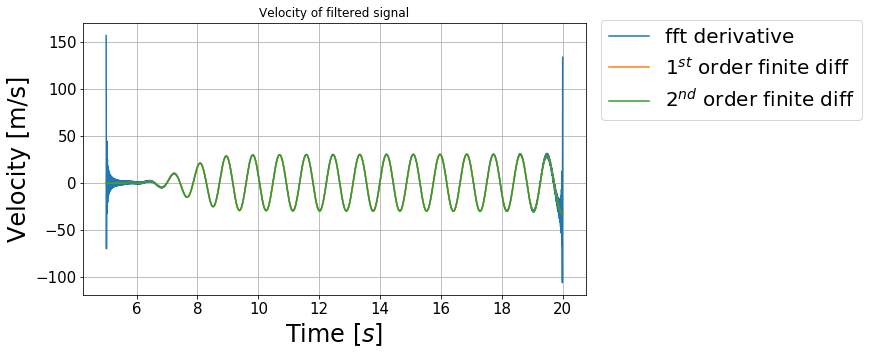

In [7]:
fig, ax = plt.subplots(figsize=(9,5))
plt.plot(x, dfFFT.real,label='fft derivative')
plt.plot(x, y_filt_prime_1st,label='$1^{st}$ order finite diff')
plt.plot(x, y_filt_prime_2nd,label='$2^{nd}$ order finite diff')
plt.legend(fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xlabel('Time $[s]$',fontsize=24)
plt.ylabel('Velocity [m/s]',fontsize=24)
plt.grid()
plt.title('Velocity of filtered signal')
plt.legend(bbox_to_anchor=(1.01, 1.05), fontsize=20)  
plt.show()

In [8]:
y_filt_fft_prime2 = -kappa**2 * y_filt_fft
ddfFFT = np.real(np.fft.ifft(y_filt_fft_prime2))

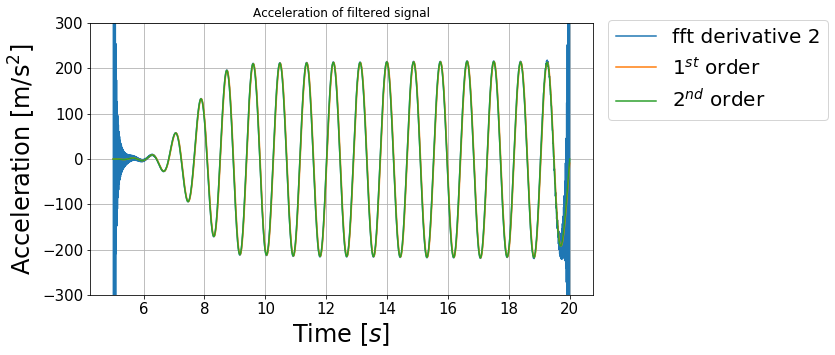

In [9]:
fig, ax = plt.subplots(figsize=(9,5))
plt.plot(x, ddfFFT.real,label='fft derivative 2')
plt.plot(x, y_filt_prime2_1st,label='$1^{st}$ order')
plt.plot(x, y_filt_prime2_2nd,label='$2^{nd}$ order')
plt.legend(fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xlabel('Time $[s]$',fontsize=24)
plt.ylabel('Acceleration [m/s$^2$]',fontsize=24)
plt.ylim([-300, 300])
# plt.xlim([19.9, 20])
plt.grid()
plt.title('Acceleration of filtered signal')
plt.legend(bbox_to_anchor=(1.01, 1.05), fontsize=20)       
plt.show()

Derivatives obtained in the frequency domain obtain results in line with finite differences on the filtered signal. Oscillation are present at the extremes due to the fact that the Fourier transform is based on the assumptions of a $\textbf{periodic and infinite}$ signal. Assumptions that are not fulfilled in this case